Reproduce the results of the RNN with FastText embedding and 8 units in the GRU layer, on the balanced dataset.

In [1]:
import numpy as np
import tensorflow as tf
import pickle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt

#import part of test set. The whole one is too big for GitHub
with open('partial_test_sentences_fasttext.pickle','rb') as file:
    test_sentences = pickle.load(file)
    
with open('partial_test_labels.pickle','rb') as file:
    test_labels = pickle.load(file)


/Users/claire/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
#input processing
seq_len_test = []
num_test=len(test_sentences)
max_input_len=41
test_exemples = np.zeros((num_test, max_input_len, 300))
for (i,sent) in enumerate(test_sentences):
        cur_len = len(list(sent))
        for (j,vect) in enumerate(sent):
            test_exemples[i,j,:] = vect
        seq_len_test.append(cur_len)
seq_len_test=np.asarray(seq_len_test)

INFO:tensorflow:Restoring parameters from rnn_fasttext_8units
Test Accuracy  0.712, Test AUC  0.751, Test Sensitivity  0.585, Test Specificity  0.808


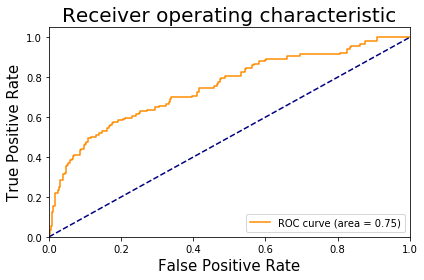

In [3]:
sess=tf.Session()    

# load meta graph and restore weights
saver = tf.train.import_meta_graph('rnn_fasttext_8units.meta')
saver.restore(sess,'rnn_fasttext_8units')

graph = tf.get_default_graph()

x_pl = graph.get_tensor_by_name("X_input:0")
y_pl = graph.get_tensor_by_name("output:0")
x_len = graph.get_tensor_by_name("X_len:0")
threshold_pl = graph.get_tensor_by_name("threshold:0")
l_out=graph.get_tensor_by_name("l_out:0")
accuracy=graph.get_tensor_by_name("performance/accuracy:0")
specificity=graph.get_tensor_by_name("performance/specificity:0")
predictions=graph.get_tensor_by_name("performance/predictions:0")

threshold=0.35

feed_dict_test = {x_pl: test_exemples, x_len: seq_len_test, y_pl: test_labels, threshold_pl : threshold}
fetches_test = [accuracy, specificity, predictions, l_out]
test_acc, test_spec, test_pred, test_prob = sess.run(fetches_test, feed_dict_test)

fpr_test, tpr_test, _ = roc_curve(test_labels, test_prob[:,1])
test_auc = auc(fpr_test, tpr_test)
TN, FP, FN, TP = confusion_matrix(test_labels, test_pred).ravel()
test_sens = TP / float(FN + TP) 
    
print('Test Accuracy {:6.3f}, Test AUC {:6.3f}, Test Sensitivity {:6.3f}, Test Specificity {:6.3f}'.format(
                test_acc, test_auc, test_sens, test_spec))

plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve (area = %0.2f)' % test_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()